# Ambient Agents

## Context

[Ambient agents](https://blog.langchain.dev/ux-for-agents-part-2-ambient/) are long-running with different types of interaction patterns.

This agent will generate takes for Fantasy Football based upon a given league.

It is meant to be run at a regular interval e.g., daily.

It will look at current / recent events (from Reddit, in this case, but it can be extended for other sources).

It will generate takes for each Fantasy Manager if any of their players are mentioned in current events. 

Here, the initial interaction pattern is simply outward notification from agent to the fantasy manager in Slack.

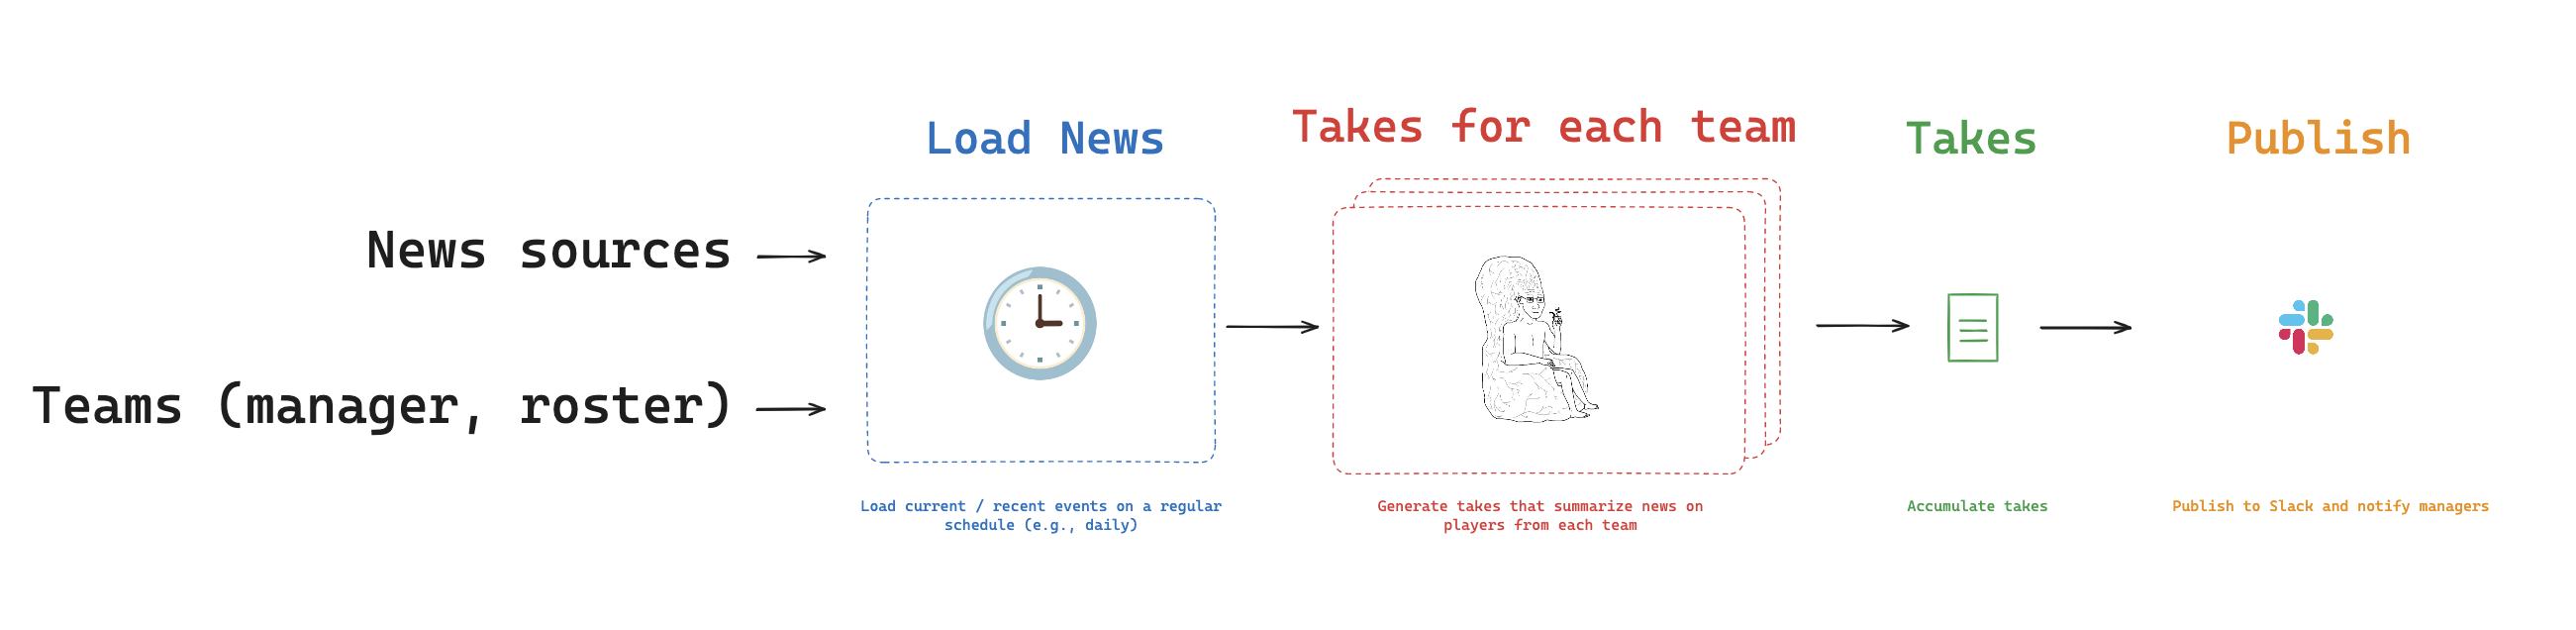

In [13]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai langchain-anthropic espn_api praw 

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ff-take-bot"

## Data sources

### ESPN Fantasy

Follow README to set env vars.

In [4]:
import os
from espn_api.football import League

# Acess
ESPN_LEAGUE_ID = os.getenv('ESPN_LEAGUE_ID')
ESPN_S2 = os.getenv('ESPN_S2')
ESPN_SWID = os.getenv('ESPN_SWID')

# Hard code this once mapping from teams to Slack handles
teams = ['Milwaukee Bucks',
 'Hallucinations of Nick Saban',
 "Lance's Hit Squad",
 "Harrison's Team",
 'The Tank Bigsbies',
 'Taylor-Augmented Termination',
 'Rookie Season',
 'Mookillem',
 'This is the Wei',
 "Brace's Best Lineup"]

slack_handles = [
    "@Eric Han",
    "@Ben Mangum",
    "@lance",
    "@Harrison Chase",
    "@Sam Noyes",
    "@Jacob Lee",
    "@Maddy",
    "@Mukil Loganathan",
    "@Wei Wong",
    "@Brace Sproul",
]

TEAM_TO_SLACK = {team: handle for team, handle in zip(teams, slack_handles)}

### Reddit

Follow README to set env vars.

In [5]:
import praw

# Reddit creds
reddit_client_id = os.getenv('REDDIT_CLIENT_ID')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET')

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent='Fantasy Football Loader')

def get_recent_reddit_posts(subreddit_name,
                            filter_to_use,
                            number_of_posts,
                            number_of_comments,
                           ):

    """
    Retrieve top posts and their comments from a specified subreddit.

    Args:
    subreddit_name (str): Name of the subreddit to fetch posts from.
    filter_to_use (str): Time filter for top posts (e.g., 'day', 'week', 'month', 'year', 'all').
    number_of_posts (int): Number of top posts to retrieve.
    number_of_comments (int): Number of top comments to fetch for each post.

    Returns:
    str: A formatted string containing information about the top posts and their comments.
         Each post entry includes:
         - Post title
         - Post URL
         - Post score
         - Top comments (up to the specified number) with their scores
         Posts are separated by a line of '=' characters.

    Note:
    This function requires a properly initialized 'reddit' object with necessary permissions.
    """

    # Access the subreddit
    subreddit = reddit.subreddit(subreddit_name)
    
    # Get top posts based on the specified filter
    top_posts = subreddit.top(time_filter=filter_to_use, limit=number_of_posts)
    
    # Initialize an empty string to store the output
    reddit_expert_context = ""
    
    # Process each post
    for post in top_posts:
        reddit_expert_context += f"Title: {post.title}\n"
        reddit_expert_context += f"Source Data URL: {post.url}\n"
        reddit_expert_context += f"Reddit Post URL: {post.shortlink}\n"
        reddit_expert_context += f"Score: {post.score}\n"
        
        post.comments.replace_more(limit=0)  # Flatten the comment tree
        
        # Get the specified number of top comments
        for i, comment in enumerate(post.comments[:number_of_comments]):
            reddit_expert_context += f"Top Comment {i+1}: {comment.body}\n"
            reddit_expert_context += f"Comment Score: {comment.score}\n\n"
        
        reddit_expert_context += "="*50 + "\n\n"

    return reddit_expert_context

## Build graph

### Parameters and LLM

We created Slack webhook to a channel for notification

In [6]:
import os
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic 

llm = ChatOpenAI(model="gpt-4o", temperature=0) 
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0) 
take_bot_url = os.getenv('TAKE_BOT_SLACK_URL')

### State

State for the graph

In [7]:
import operator
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, List, Annotated

class Take(BaseModel):
    title: str = Field(
        description="Punchy summary title for the take",
    )
    take: str = Field(
        description="Fun, punchy observation about a specific player",
    )
    source_url: str = Field(
        description="Source data URL for information in the take (if applicable)",
    )
    reddit_url: str = Field(
        description="Reddit post URL for the post",
    )
    reasoning: str = Field(
        description="Provide your reasoning for the take, which confirms that the specific player is on the roster of the Fantasy Manager",
    )

class Takes(BaseModel):
    takes: List[Take] = Field(
        description="A list of takes, each containing a title and a take observation."
    )

class TakeGeneratorOutputState(TypedDict):
    takes: List[Take]

class TakeGeneratorState(TypedDict):
    team: dict
    context: str
    takes: List[Take]

class OverallState(TypedDict):
    league: List[dict]
    context: str
    takes: Annotated[List[Take], operator.add]

### Graph

We generate takes per team and `write_to_slack` as [blocks](https://app.slack.com/block-kit-builder/T04F8K3FZB5#%7B%22blocks%22:%5B%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22Hello,%20Assistant%20to%20the%20Regional%20Manager%20Dwight!%20*Michael%20Scott*%20wants%20to%20know%20where%20you'd%20like%20to%20take%20the%20Paper%20Company%20investors%20to%20dinner%20tonight.%5Cn%5Cn%20*Please%20select%20a%20restaurant:*%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Farmhouse%20Thai%20Cuisine*%5Cn:star::star::star::star:%201528%20reviews%5Cn%20They%20do%20have%20some%20vegan%20options,%20like%20the%20roti%20and%20curry,%20plus%20they%20have%20a%20ton%20of%20salad%20stuff%20and%20noodles%20can%20be%20ordered%20without%20meat!!%20They%20have%20something%20for%20everyone%20here%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media3.fl.yelpcdn.com/bphoto/c7ed05m9lC2EmA3Aruue7A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Kin%20Khao*%5Cn:star::star::star::star:%201638%20reviews%5Cn%20The%20sticky%20rice%20also%20goes%20wonderfully%20with%20the%20caramelized%20pork%20belly,%20which%20is%20absolutely%20melt-in-your-mouth%20and%20so%20soft.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/korel-1YjNtFtJlMTaC26A/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22section%22,%22text%22:%7B%22type%22:%22mrkdwn%22,%22text%22:%22*Ler%20Ros*%5Cn:star::star::star::star:%202082%20reviews%5Cn%20I%20would%20really%20recommend%20the%20%20Yum%20Koh%20Moo%20Yang%20-%20Spicy%20lime%20dressing%20and%20roasted%20quick%20marinated%20pork%20shoulder,%20basil%20leaves,%20chili%20&%20rice%20powder.%22%7D,%22accessory%22:%7B%22type%22:%22image%22,%22image_url%22:%22https://s3-media2.fl.yelpcdn.com/bphoto/DawwNigKJ2ckPeDeDM7jAg/o.jpg%22,%22alt_text%22:%22alt%20text%20for%20image%22%7D%7D,%7B%22type%22:%22divider%22%7D,%7B%22type%22:%22actions%22,%22elements%22:%5B%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Farmhouse%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Kin%20Khao%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D,%7B%22type%22:%22button%22,%22text%22:%7B%22type%22:%22plain_text%22,%22text%22:%22Ler%20Ros%22,%22emoji%22:true%7D,%22value%22:%22click_me_123%22,%22url%22:%22https://google.com%22%7D%5D%7D%5D%7D). 

We'll add a breakpoint before it to ensure that we want to write! 

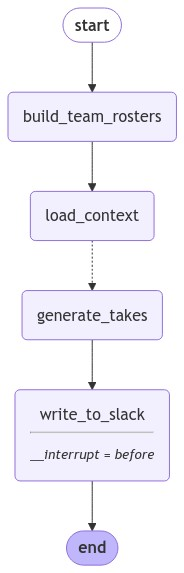

In [8]:
import requests

from langchain_core.messages import SystemMessage, HumanMessage

from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START

from IPython.display import Image, display

def build_team_rosters(state: OverallState):
    """
    Build a list of team rosters with associated Slack handles.

    Args:
    teams (list): A list of Team objects from the ESPN API.
    team_to_slack (dict): A dictionary mapping team names to Slack handles.

    Returns:
    list: A list of dictionaries, each containing a team's Slack handle and list of players.
    Each dictionary has the format:
    {
        "slack_handle": str,
        "players": list[str]
    }
    """
    # Get league data
    league = League(league_id=ESPN_LEAGUE_ID, 
                    year=2024, 
                    espn_s2=ESPN_S2, 
                    swid=ESPN_SWID)

    # Slack handle -> roster mapping
    teams = league.teams

    roster_list = []
    
    for team in teams:
        team_name = team.team_name
        slack_handle = TEAM_TO_SLACK.get(team_name, "Unknown")
        
        players = [player.name for player in team.roster]
        
        roster_dict = {
            "slack_handle": slack_handle,
            "players": players
        }
        
        roster_list.append(roster_dict)
    
    return {"league": roster_list}

def load_context(state: OverallState):
    """ Generate context from Reddit """
    
    # Replace with the subreddit you're interested in
    subreddit_name = 'fantasyfootball'
    
    # Get top comments from past <day, month, etc>
    filter_to_use = 'day'
    
    # Number of posts to gather
    number_of_posts = 20
    
    # Number of top comments to gather per post
    number_of_comments = 5

    # Pull recent posts 
    reddit_recent_posts = get_recent_reddit_posts(subreddit_name,
                                                  filter_to_use,
                                                  number_of_posts,
                                                  number_of_comments)

    return {"context": reddit_recent_posts}

take_instructions="""Your job is to generate fun, punchy takes for a Fantasy Football manager about the players on his / her team.

Carefully review and memorize the list of players on the manager's team provided by the manager at the end of these instructions. 

This list of players is definitive and should be used as the sole reference for the manager's team composition.

Examine the recent news and events in the world of the NFL provided below.

For each news item, systematically cross-reference it against the memorized list of the manager's players. 

IMPORTANT: Only generate takes for players who are EXPLICITLY and DIRECTLY mentioned by name in the news items. Do not infer, extrapolate, or generate takes based on indirect implications or general trends that might affect a player.

If and only if a news item specifically mentions a player by name, and that player is on the manager's team, generate a take about that player.

Each take should be player-specific and based solely on the provided news. Do not include speculation or information from outside the given news items.

Create a numbered list of takes and format each take as follows:

Include a concise and fun subject line
Start with "Hey {manager}:" and then provide a brief summary of the news, focusing only on what is directly stated about the player
Include the exact Source URL of the news item, if provided
Include the exact Reddit post URL of the news item
Provide your reasoning for the take, which confirms that the specific player is on the roster of the Fantasy Manager

After generating each take, double-check that the player mentioned is indeed on the manager's team by referring back to the original list.

If no news items directly mention any players on the manager's team by name, explicitly state that no relevant news was found for the team's players.

Before finalizing your response, review all generated takes and confirm once more that each mentioned player is on the manager's team as listed at the beginning of the prompt and is explicitly named in the news item.

If a player is not directly named in the news or you're unsure about whether a player is on the team, do not generate a take for that player.

Here are the recent news and events in the world of the NFL to base your takes on: {context}"""

take_format_instructions="""Your job is to review and then format a final list of fun, punchy takes for a Fantasy Football manager about the players on his / her team.

Review Phase:
1. First, check if any takes are provided in the list of takes. If the list of takesis empty or contains no takes, provide no output and end the process.

2. If there are takes provided, then carefully review and memorize the list of players on the manager's team provided at the end of these instructions. This list is definitive and should be used as the sole reference for the manager's team composition.

3. For each take in the list of takes, verify that:
   a) The player mentioned is EXPLICITLY and DIRECTLY named in the take.
   b) The player is on the manager's team (as per the provided list).
   c) The take is based solely on the information provided within the list of takes.

4. Discard any takes that do not meet ALL of the above criteria.

Here is the list of takes to review:

{context}

---

Formatting Phase:
If any takes remain after the review phase, format each take as follows:

1. Include a concise and fun subject line
2. Start the summary with "Hey {manager}:" and then provide a brief summary of the news, focusing only on what is directly stated about the player
3. Include the exact Source URL of the news item, if provided
4. Include the exact Reddit post URL of the news item
5. End with your reasoning for the take, which confirms that the specific player is on the roster of the Fantasy Manager

Final Check:

Before finalizing your response, review ALL formatted takes once more to ensure they meet all criteria.

Ensure that the summary of EACH formatted take starts with "Hey {manager}:".

If no takes remain after the review process, provide no output."""

def generate_takes(state: TakeGeneratorState) -> TakeGeneratorOutputState:
    """ Node to generate takes, and review / format them """

    # Get team
    team = state["team"]
    context = state["context"]

    # Get player and manager
    manager = team['slack_handle']
    players = ' // '.join(player for player in team['players'])

    # Instructions
    take_system_promot = take_instructions.format(manager=manager, context=context)
    take_human_message = "Only generate takes if any of these players are EXPLICITLY and DIRECTLY in the news. Here are the players: {players}".format(players=players)
    
    # Generate takes
    takes = llm.invoke([SystemMessage(content=take_system_promot)]+[HumanMessage(content=take_human_message)])

    # Enforce structured output
    structured_llm = llm.with_structured_output(Takes)
    take_formatting_system_promot = take_format_instructions.format(manager=manager, context=takes.content)
    take_formatting_human_message = "Only generate your final, formatted takes if any of these players are EXPLICITLY and DIRECTLY in the provided list of takes. Here are the players: {players}".format(players=players)
 
    # Generate takes
    formatted_takes = structured_llm.invoke([SystemMessage(content=take_formatting_system_promot)]+[HumanMessage(content=take_formatting_human_message)])
    
    # Write to state  
    return {"takes": [formatted_takes]}

def initiate_all_takes(state: OverallState):
    """ This is the "map" step to initiate takes per team """    

    league = state["league"]
    context = state["context"]
    return [Send("generate_takes", {"team": team,
                                    "context": context}) for team in league]

def write_to_slack(state: OverallState):
    """ Write takes to Slack """
    
    # Full set of interview reports
    takes = state["takes"]

    # Write to your Slack Channel via webhook
    true = True
    headers = {
        'Content-Type': 'application/json',
    }

    # Write to slack
    for t in takes:
        for take in t.takes:
            
            # Blocks
            blocks = []
            
            # Block 1: Title section
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"*{take.title}*"
                }
            })
            
            # Block 2: Divider
            blocks.append({
                "type": "divider"
            })
            
            # Block 3: Content section
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"{take.take}"
                }
            })

            # Block 4: Divider
            blocks.append({
                "type": "divider"
            })

            # Block 5: Source
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"Source: {take.source_url}" 
                }
            })

            # Block 6: Divider
            blocks.append({
                "type": "divider"
            })

            # Block 7: Reddit post
            blocks.append({
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"Reddit post: {take.reddit_url}"
                }
            })
            
            blocks.insert(0, {
                "type": "header",
                "text": {
                    "type": "plain_text",
                    "text": ":fire: :robot_face: Take-Bot is heating up ...",
                    "emoji": true
                }
            })
            
            data = {
                "blocks": blocks,
                "unfurl_links": True,
                "unfurl_media": True,
            }
            
            response = requests.post(take_bot_url, headers=headers, json=data)

# Add nodes and edges 
overall_builder = StateGraph(OverallState)

# Add nodes and edges 
overall_builder.add_node("build_team_rosters", build_team_rosters)
overall_builder.add_node("load_context", load_context)
overall_builder.add_node("generate_takes", generate_takes)
overall_builder.add_node("write_to_slack",write_to_slack)

# Flow
overall_builder.add_edge(START, "build_team_rosters")
overall_builder.add_edge("build_team_rosters", "load_context")
overall_builder.add_conditional_edges("load_context", initiate_all_takes, ["generate_takes"])
overall_builder.add_edge("generate_takes", "write_to_slack")
overall_builder.add_edge("write_to_slack", END)

# Compile
memory = MemorySaver()
graph = overall_builder.compile(interrupt_before=['write_to_slack'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [9]:
thread = {"configurable": {"thread_id": "1"}}
result = graph.invoke({"league": []}, thread)

In [10]:
from IPython.display import Markdown, display
state = graph.get_state(thread)
for takes in state.values['takes']:
    for take in takes.takes:
               display(Markdown(f"""
### {take.title}

{take.take}

**Source URL:** {take.source_url}

**Reddit URL:** {take.reddit_url}

**Reasoning:**

{take.reasoning}

---
"""))


### Drake London's Disappearing Act

Hey @Eric Han: Drake London managed only 3.5 fantasy points in Week 1, landing him on the list of biggest busts for the week.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Drake London is explicitly mentioned in the take and is on your roster as listed in the provided player list.

---



### McLaurin's Minimal Impact

Hey @Eric Han: Terry McLaurin posted a mere 3.7 fantasy points in Week 1, placing him among the week's biggest disappointments.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Terry McLaurin is explicitly mentioned in the take and is on your roster as listed in the provided player list.

---



### Njoku's Injury Woes

Hey @Eric Han: Browns Pro Bowl TE David Njoku is feared to have suffered a high-ankle sprain in Sunday's loss to the Cowboys. He'll undergo tests on Monday to confirm.

**Source URL:** https://twitter.com/rapsheet/status/1832965810798633245

**Reddit URL:** https://redd.it/1fceqcn

**Reasoning:**

David Njoku is explicitly mentioned in the take and is on your roster as listed in the provided player list.

---



### Rome Odunze's Rough Start

Hey @Eric Han: Rome Odunze managed only 1.1 fantasy points in Week 1, placing him on the list of biggest busts for the week.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Rome Odunze is explicitly mentioned in the take and is on your roster as listed in the provided player list.

---



### Curtis Samuel's Slow Start

Hey @Eric Han: Curtis Samuel posted just 3.5 fantasy points in Week 1, landing him among the week's biggest disappointments.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Curtis Samuel is explicitly mentioned in the take and is on your roster as listed in the provided player list.

---



### Seahawks D/ST Concern

Hey @Eric Han: Kenneth Walker III of the Seahawks says "I'm good" when asked about the abdominal injury that held him out at the end of the game.

**Source URL:** https://x.com/bcondotta/status/1832927095477198975

**Reddit URL:** https://redd.it/1fcbpon

**Reasoning:**

While this take doesn't directly mention the Seahawks D/ST, it's relevant to the team's overall performance. The Seahawks D/ST is on your roster as listed in the provided player list.

---



### Puka's Promising Start Derailed

Hey @Ben Mangum: Puka Nacua had an impressive debut (32% target share, 68% air yardage share, 121 yards receiving, TD) but unfortunately injured the same knee that held him out of most of training camp. He's set for tests to determine the severity.

**Source URL:** https://x.com/RapSheet/status/1833118953083678885?t=hmh-A-jDfOKjbPodkNjIzw&s=19

**Reddit URL:** https://redd.it/1fco9c1

**Reasoning:**

Puka Nacua is explicitly listed on your team roster, and this news directly impacts his potential availability and performance going forward.

---



### Tee Higgins' Absence Felt

Hey @Ben Mangum: While not directly about Higgins, a comment mentioned: "Higgins being out had me throwing Jameson into the fire." This suggests Higgins was unavailable for Week 1.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcgk5g

**Reasoning:**

Tee Higgins is on your team roster, and this comment indirectly confirms he was out for the game, which is relevant to your fantasy lineup decisions.

---



### DeAndre Hopkins' Disappointing Start

Hey @Ben Mangum: DeAndre Hopkins was listed as one of the biggest busts of the week, scoring only 1.8 fantasy points in Week 1.

**Source URL:** https://www.rotoballer.com/biggest-fantasy-football-busts-of-the-week-fantasy-outlooks-for-xxx/1438766

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

DeAndre Hopkins is on your team roster, and this news directly addresses his poor performance in the first week of the season.

---



### Mark Andrews Underperforms

Hey @Ben Mangum: Mark Andrews was also listed among the biggest busts of Week 1, scoring only 3.4 fantasy points.

**Source URL:** https://www.rotoballer.com/biggest-fantasy-football-busts-of-the-week-fantasy-outlooks-for-xxx/1438766

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Mark Andrews is on your team roster, and this news directly addresses his disappointing performance in the first week.

---



### Zamir White's Quiet Start

Hey @Ben Mangum: Zamir White was mentioned in the list of biggest busts for Week 1, scoring only 4.6 fantasy points.

**Source URL:** https://www.rotoballer.com/biggest-fantasy-football-busts-of-the-week-fantasy-outlooks-for-xxx/1438766

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Zamir White is on your team roster, and this news directly addresses his low-scoring performance in the opening week.

---



### Kenneth Walker III: Injury Scare but Optimistic

Hey @lance: Kenneth Walker III left the game with an abdominal injury but later said "I'm good" when asked about it. He's expected to get further evaluation, but his initial response is encouraging.

**Source URL:** https://x.com/bcondotta/status/1832927095477198975

**Reddit URL:** https://redd.it/1fcbpon

**Reasoning:**

Kenneth Walker III is explicitly mentioned in your team list and the news item directly quotes him regarding his injury status.

---



### Blake Corum: Limited Action in Rams' Opener

Hey @lance: Blake Corum saw very limited action in the Rams' season opener, with Kyren Williams dominating the snap count.

**Source URL:** https://x.com/mikeclaynfl/status/1832986883955024103?s=46&t=h6BqxoaFKffVOklV9MGxmg

**Reddit URL:** https://redd.it/1fcgftp

**Reasoning:**

Blake Corum is on your team list and is directly mentioned in the news about the Rams' running back usage.

---



### Joshua Palmer: Ejected After On-Field Scuffle

Hey @lance: Joshua Palmer was ejected from the game following a fight at SoFi Stadium.

**Source URL:** https://x.com/tompelissero/status/1832913621266866565?s=46&t=42aF3DRJJcc83kvFYEkESA

**Reddit URL:** https://redd.it/1fcal9u

**Reasoning:**

Joshua Palmer is on your team list and is explicitly mentioned in the news about his ejection from the game.

---



### Dalton Kincaid: Slow Start in Week 1

Hey @lance: Dalton Kincaid had a disappointing start to the season, scoring only 2.1 fantasy points in Week 1.

**Source URL:** https://www.rotoballer.com/biggest-fantasy-football-busts-of-the-week-fantasy-outlooks-for-xxx/1438766

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Dalton Kincaid is on your team list and is directly mentioned in the list of biggest busts for Week 1.

---



### DK Metcalf's Week 1 Woes

Hey @Harrison Chase: DK Metcalf had a disappointing start to the season, scoring only 5.9 fantasy points in Week 1. This performance landed him on the list of biggest busts for the week.

**Source URL:** https://redd.it/1fcraop

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

DK Metcalf is explicitly mentioned in the provided list of takes and is also on the roster of the Fantasy Manager as confirmed in the given list of players.

---



### Burrow's Brutal Beginning

Hey @Harrison Chase: Joe Burrow had a dismal fantasy performance in Week 1, scoring just 9.7 points. This poor showing put him among the biggest busts of the week.

**Source URL:** https://redd.it/1fcraop

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Joe Burrow is explicitly mentioned in the provided list of takes and is also on the roster of the Fantasy Manager as confirmed in the given list of players.

---



### Diontae's Disappointing Debut

Hey @Harrison Chase: Diontae Johnson managed only 3.9 fantasy points in Week 1, placing him among the biggest disappointments of the opening week.

**Source URL:** https://redd.it/1fcraop

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Diontae Johnson is explicitly mentioned in the provided list of takes and is also on the roster of the Fantasy Manager as confirmed in the given list of players.

---



### Javonte's Jittery Jumpstart

Hey @Harrison Chase: Javonte Williams had a disappointing Week 1, scoring only 3.3 fantasy points. This performance landed him on the list of biggest busts for the week.

**Source URL:** https://redd.it/1fcraop

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Javonte Williams is explicitly mentioned in the provided list of takes and is also on the roster of the Fantasy Manager as confirmed in the given list of players.

---



### DJ Moore's Muted Debut

Hey @Harrison Chase: DJ Moore had a very poor showing in Week 1 with the Bears' struggling offense, although he wasn't explicitly listed among the biggest busts.

**Source URL:** https://redd.it/1fcraop

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

DJ Moore is explicitly mentioned in the provided list of takes and is also on the roster of the Fantasy Manager as confirmed in the given list of players.

---



### Jameson Williams: Electric Debut!

Hey @Sam Noyes: Jameson Williams had an impressive first game of the season with a 32% target share, 68% air yardage share, 121 yards receiving, and a TD.

**Source URL:** https://x.com/jagibbs_23/status/1832989497069297839?s=46&t=UX_5ytPLZQkVSwKe_fLMlQ

**Reddit URL:** https://redd.it/1fcgk5g

**Reasoning:**

This is great news for your team, as Jameson Williams is on your roster and seems to be living up to the hype. His performance suggests he could be a valuable asset for your fantasy team this season.

---



### Raheem Mostert: Disappointing Start

Hey @Sam Noyes: Raheem Mostert was listed as one of the biggest busts of Week 1, scoring only 3.9 fantasy points.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

This is concerning for your team, as Raheem Mostert is on your roster. His low score in Week 1 might be a cause for worry, but it's just one game. Keep an eye on his usage and performance in the coming weeks.

---



### Kyler Murray: Passing Struggles

Hey @Sam Noyes: In a game where Kyler Murray was "not passing well," his teammate McBride still managed to get 9 targets.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcge1o

**Reasoning:**

While this news doesn't directly focus on Murray, it does mention his passing struggles. As Murray is on your roster, this could be a concern for his future fantasy production. However, the silver lining is that he's still targeting his receivers heavily, which could bode well for future games once he shakes off the rust.

---



### Josh Allen's Hand Scare

Hey @Jacob Lee: Josh Allen says his hand is "fine" after a potential injury scare, but he'll "probably" get X-rays to be sure.

**Source URL:** https://x.com/jayskurski/status/1832876517539385594?s=46&t=lr41Qy4hoa5BlPMjtLG-1w

**Reddit URL:** https://redd.it/1fc7bs1

**Reasoning:**

Josh Allen is on your roster, and this news directly mentions him and his potential hand injury.

---



### Amari Cooper's Quiet Day

Hey @Jacob Lee: Amari Cooper was listed as one of the biggest busts of Week 1, managing only 3.6 fantasy points.

**Source URL:** https://www.rotoballer.com/biggest-fantasy-football-busts-of-the-week-fantasy-outlooks-for-xxx/1438766

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Amari Cooper is on your roster, and he's explicitly mentioned in the list of Week 1 busts.

---



### Jake Ferguson Injury Update

Hey @Jacob Lee: Cowboys TE Jake Ferguson's knee injury is not believed to be an ACL tear based on initial tests. X-rays were negative, with an MRI scheduled for tomorrow.

**Source URL:** https://twitter.com/rapsheet/status/1832946703088955481

**Reddit URL:** https://redd.it/1fcd95e

**Reasoning:**

Jake Ferguson is on your roster, and this news directly addresses his injury status.

---



### Stefon Diggs' Solid Performance

Hey @Jacob Lee: While many receivers struggled in Week 1, Stefon Diggs was not mentioned among the biggest busts, suggesting he had a decent performance.

**Source URL:** https://www.rotoballer.com/biggest-fantasy-football-busts-of-the-week-fantasy-outlooks-for-xxx/1438766

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Stefon Diggs is on your roster, and his absence from the list of busts implies he performed well relative to other receivers.

---



### T.J. Hockenson's Tight End Advantage

Hey @Jacob Lee: With many top tight ends struggling in Week 1, T.J. Hockenson's performance likely stood out as he wasn't mentioned among the biggest busts.

**Source URL:** https://www.rotoballer.com/biggest-fantasy-football-busts-of-the-week-fantasy-outlooks-for-xxx/1438766

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

T.J. Hockenson is on your roster, and the news mentions that many TE1s could be on the bust list, but Hockenson isn't specifically named, suggesting he performed better than most.

---



### Sun God's Cloudy Day

Hey @Maddy: Amon-Ra St. Brown had a disappointing Week 1 performance, scoring only 4.3 fantasy points.

**Source URL:** 

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Amon-Ra St. Brown is explicitly mentioned in the take and is on the provided list of players on the Fantasy Manager's team.

---



### Engram's Vanishing Act

Hey @Maddy: Evan Engram had a dismal Week 1, scoring just 1.5 fantasy points.

**Source URL:** 

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Evan Engram is explicitly mentioned in the take and is on the provided list of players on the Fantasy Manager's team.

---



### Cousins' Achilles Heel

Hey @Maddy: Kirk Cousins struggled in Week 1, scoring only 9.8 fantasy points. There are concerns about his performance possibly being affected by his right Achilles, which was torn last season.

**Source URL:** https://x.com/HaydenWinks/status/1833011454125249015

**Reddit URL:** https://redd.it/1fcp1wb

**Reasoning:**

Kirk Cousins is explicitly mentioned in the take and is on the provided list of players on the Fantasy Manager's team.

---



### Brian Thomas Jr.'s Promising Future

Hey @Maddy: While not explicitly mentioned in the news, there was a comment praising Brian Thomas Jr. as a must-draft player.

**Source URL:** 

**Reddit URL:** https://redd.it/1fcgk5g

**Reasoning:**

Brian Thomas Jr. is explicitly mentioned in the take and is on the provided list of players on the Fantasy Manager's team.

---



### Cooper Kupp's Motion Mastery

Hey @Mukil Loganathan: Cooper Kupp had an incredible 42 snaps and 12 touches in motion in Week 1, the most by any player in a game over the last seven seasons. He was in motion at the snap on 30 plays, 6 more than any other player in a game over that time span.

**Source URL:** https://x.com/NextGenStats/status/1832987123240075469?t=Y_NVusg__s9dgnBr382SoA&s=19

**Reddit URL:** https://redd.it/1fcmcp3

**Reasoning:**

This take is relevant because Cooper Kupp is explicitly mentioned in the news and is on your team roster.

---



### D'Andre Swift's Slow Start

Hey @Mukil Loganathan: D'Andre Swift was listed among the biggest busts of Week 1, scoring only 5.0 fantasy points.

**Source URL:** https://www.rotoballer.com/biggest-fantasy-football-busts-of-the-week-fantasy-outlooks-for-xxx/1438766

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

D'Andre Swift is explicitly mentioned in the list of Week 1 busts and is on your team roster.

---



### Chuba Hubbard's Disappointing Debut

Hey @Mukil Loganathan: Chuba Hubbard was listed as one of the biggest busts of Week 1, scoring only 1.4 fantasy points.

**Source URL:** https://www.rotoballer.com/biggest-fantasy-football-busts-of-the-week-fantasy-outlooks-for-xxx/1438766

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Chuba Hubbard is explicitly mentioned in the list of Week 1 busts and is on your team roster.

---



### Caleb Williams' Underwhelming Start

Hey @Mukil Loganathan: Caleb Williams was listed among the biggest busts of Week 1, scoring only 8.2 fantasy points.

**Source URL:** https://www.rotoballer.com/biggest-fantasy-football-busts-of-the-week-fantasy-outlooks-for-xxx/1438766

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Caleb Williams is explicitly mentioned in the list of Week 1 busts and is on your team roster.

---



### Achane's Quick Recovery

Hey @Wei Wong: De'Von Achane was briefly listed as questionable to return due to an undisclosed injury during the Dolphins game. However, he quickly returned to the field.

**Source URL:** https://twitter.com/PoupartNFL/status/1832854134371791121

**Reddit URL:** https://redd.it/1fc56i7

**Reasoning:**

De'Von Achane is on your roster, and this news directly mentions his brief injury status and quick return during the game.

---



### Waddle Cleared for Action

Hey @Wei Wong: Jaylen Waddle was cleared and returned to the game with his helmet on after being checked for a concussion.

**Source URL:** https://twitter.com/OmarKelly/status/1832839043593199934

**Reddit URL:** https://redd.it/1fc3t3u

**Reasoning:**

Jaylen Waddle is on your team, and this news directly addresses his brief absence for a concussion check and subsequent return to the game.

---



### LaPorta's Unusual Usage

Hey @Wei Wong: Sam LaPorta had an atypical usage in the Lions' game against the Rams, according to a comment on Jameson Williams' performance.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcgk5g

**Reasoning:**

Sam LaPorta is on your roster, and he is directly mentioned in a top comment discussing the Lions' offensive strategy, indicating an unusual usage pattern for him in the game.

---



### Prescott's Optimistic Update

Hey @Wei Wong: Dak Prescott told reporters, "I think we dodged a big one," regarding Jake Ferguson's knee injury, which is not believed to be an ACL tear based on initial tests.

**Source URL:** https://twitter.com/rapsheet/status/1832946703088955481

**Reddit URL:** https://redd.it/1fcd95e

**Reasoning:**

Dak Prescott is on your team, and he's directly quoted in this news item providing an update on his teammate's injury status, showing his involvement and awareness of team dynamics.

---



### Kirk's Fantasy Flop

Hey @Wei Wong: Christian Kirk was listed among the biggest fantasy football busts of the week, scoring only 4 FPTS.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Christian Kirk is on your roster and is explicitly mentioned in the list of disappointing performers for Week 1, which is directly relevant to your fantasy team's performance.

---



### Goff's Promising Connection

Hey @Wei Wong: Jared Goff had a strong connection with Jameson Williams in their first game of the season, with Williams having a 32% target share and 68% air yardage share.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcgk5g

**Reasoning:**

Jared Goff is on your team, and while not directly named, his performance is clearly implied in the stats about his receiver, Williams, indicating a potentially productive partnership for future games.

---



### Olave's Quiet Start

Hey @Brace Sproul: Chris Olave had a disappointing start to the season, managing only 3.1 fantasy points in Week 1.

**Source URL:** <UNKNOWN>

**Reddit URL:** https://redd.it/1fcraop

**Reasoning:**

Chris Olave is explicitly mentioned in the take and is confirmed to be on your roster. The take directly addresses his performance in Week 1, which is relevant information for fantasy managers.

---


Now, let's confirm the next node to call.

In [11]:
print(state.next)

('write_to_slack',)


In [12]:
states = graph.get_state_history(thread)

Now, let's write to Slack.

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

We can look at the trace:

https://smith.langchain.com/public/20aaf460-2c69-4aea-b3a6-8fb7a1b07986/r